In [1]:
import numpy as np
import torch as th
import os
%load_ext autoreload
%autoreload 2
from PIL import Image 
from IPython.display import clear_output
from matplotlib.pyplot import imshow 
import matplotlib.pyplot as plt
import PIL
import torch

import warnings
warnings.filterwarnings('ignore')

from itertools import islice
from torchvision.transforms.functional import to_tensor

import pandas as pd
from torchvision import transforms
from itertools import product
%matplotlib inline

# Import dvec (https://github.com/Vahe1994/Deep-Vectorization-of-Technical-Drawings)
import sys
sys.path.append('./dvec/')

from util_files.rendering.cairo  import render,render_with_skeleton
from util_files.data.graphics_primitives import PT_LINE,  PT_CBEZIER, PT_QBEZIER
import util_files.loss_functions.supervised  as supervised_loss 
from util_files.optimization.optimizer.scheduled_optimizer import ScheduledOptimizer
import util_files.dataloading as dataloading
from vectorization import load_model
from util_files.patchify import patchify
from util_files.geometric import liang_barsky_screen
from util_files.data.graphics.units import Pixels
from util_files.data.graphics.graphics import Path, VectorImage
from util_files.evaluation_utils import primitive_to_path_and_crop

# Arguments generator
import sys; sys.argv=['']; del sys
import argparse

# Steps
from merging.utils.merging_functions import tensor_vector_graph_numpy,assemble_vector_patches_lines,save_svg,clip_to_box
from refinement.our_refinement.refinement_for_lines import render_optimization_hard
from merging.merging_for_lines import postprocess

## Utils

In [2]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--output_dir', type=str, default='.logs/outputs/vectorization/lines/',
                        help='dir to folder for output')
    parser.add_argument('--diff_render_it', type=int, default=300, help='iteration count')
    parser.add_argument('--init_random', action='store_true', default=False, dest='init_random',
                        help='init model with random [default: False].')
    parser.add_argument('--rendering_type', type=str, default='hard', help='hard -oleg,simple Alexey')
    parser.add_argument('--data_dir', type=str, default='.out/model/', help='dir to folder for input')
    parser.add_argument('--image_name', type=str, default='test.png',
                        help='Name of image.If None will perform to all images in '
                             'folder.[default: None]')
    parser.add_argument('--overlap', type=int, default=16, help='overlap in pixel')
    parser.add_argument('--model_output_count', type=int, default=10, help='max_model_output')
    parser.add_argument('--max_angle_to_connect', type=int, default=10, help='max_angle_to_connect in pixel')
    parser.add_argument('--max_distance_to_connect', type=int, default=15, help='max_distance_to_connect in pixel')
    return parser.parse_args()

def preprocess_image(image):
    patch_height, patch_width = image.shape[1:3]
    image = torch.as_tensor(image).type(torch.float32).reshape(-1, patch_height, patch_width) / 255
    image = 1 - image  # 0 -- background
    mask = (image > 0).type(torch.float32)
    _xs = np.arange(1, patch_width + 1, dtype=np.float32)[None].repeat(patch_height, 0) / patch_width
    _ys = np.arange(1, patch_height + 1, dtype=np.float32)[..., None].repeat(patch_width, 1) / patch_height
    _xs = torch.from_numpy(_xs)[None]
    _ys = torch.from_numpy(_ys)[None]
    return torch.stack([image, _xs * mask, _ys * mask], dim=1)

def read_data(options, image_type = 'RGB'):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    dataset = []
    if options.image_name is None:
        image_names = os.listdir(options.data_dir)
        print(image_names)
        for image_name in image_names:
            if (image_name[-4:] != 'jpeg' and image_name[-3:] != 'png' and image_name[-3:] != 'jpg') or image_name[0]=='.':
                print(image_name[-4:])
                continue
            print(os.getcwd())
            img = train_transform(Image.open(options.data_dir + image_name).convert(image_type))
            print(img.shape)
            img_t = torch.zeros(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                               img.shape[2] + (32 - img.shape[2] % 32))
            img_t[:, :img.shape[1], :img.shape[2]] = img
            dataset.append(img_t)
        options.image_name = image_names
    else:
        img = train_transform(Image.open(options.data_dir + options.image_name).convert(image_type))
        print(img.shape)
        img_t = torch.zeros(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                           img.shape[2] + (32 - img.shape[2] % 32))
        img_t[:, :img.shape[1], :img.shape[2]] = img
        dataset.append(img_t)
        options.image_name = [options.image_name]

    return dataset

def split_to_patches(rgb, patch_size, overlap=0):
    """Separates the input into square patches of specified size.

    :param rgb: input RGB image
    :type rgb: numpy.ndarray
    :param patch_size: size of patches in pixels (assuming
                        square patches)
    :type patch_size: int
    :param overlap: amount in pixels of how much the patches
                    can overlap with each other (useful for merging)
    :type overlap: int

    :returns patches, patches_offsets
    :rtype Tuple[numpy.ndarray, numpy.ndarray]
    """
    rgb = rgb.transpose(1, 2, 0)
    rgb_t = np.ones((rgb.shape[0] + 33, rgb.shape[1] + 33, rgb.shape[2])) * 255.
    rgb_t[:rgb.shape[0], :rgb.shape[1], :] = rgb
    rgb = rgb_t

    height, width, channels = rgb.shape

    assert patch_size > 0 and 0 <= overlap < patch_size
    patches = patchify(rgb,
                       patch_size=(patch_size, patch_size, channels),
                       step=patch_size - overlap)
    patches = patches.reshape((-1, patch_size, patch_size, channels))
    height_offsets = np.arange(0, height - patch_size, step=patch_size - overlap)
    width_offsets = np.arange(0, width - patch_size, step=patch_size - overlap)
    patches_offsets = np.array(list(
        product(height_offsets, width_offsets)
    ))
    return patches, patches_offsets, rgb

## Load model

In [3]:
device = torch.device('cuda:{}'.format(0))
prefetch_data = True
batches_completed_in_epoch=0
epoch_size = 20000
curve_count = 10
model_type = 'model'

# Choose json file 
model_json_param = 'dvec/vectorization/models/specs/resnet18_blocks3_bn_256__c2h__trans_heads4_feat256_blocks4_ffmaps512__h2o__out512.json'
# Load/create model 
model = load_model(model_json_param).to(device)

# Load weights
def serialize(checkpoint):
    model_state_dict = checkpoint['model_state_dict']
    keys = []
    for k in model_state_dict:
        if 'hidden.transformer' in k:
            keys.append(k)

    for k in keys:
        new_key = 'hidden.decoder.transformer' + k[len('hidden.transformer'):]
        model_state_dict[new_key] = model_state_dict[k]
        del model_state_dict[k]
    return checkpoint

checkpoint = serialize(torch.load('dvec/vectorization/models/weights/model_lines.weights'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Process image

torch.Size([1, 949, 1418])


(-0.5, 1439.5, 959.5, -0.5)

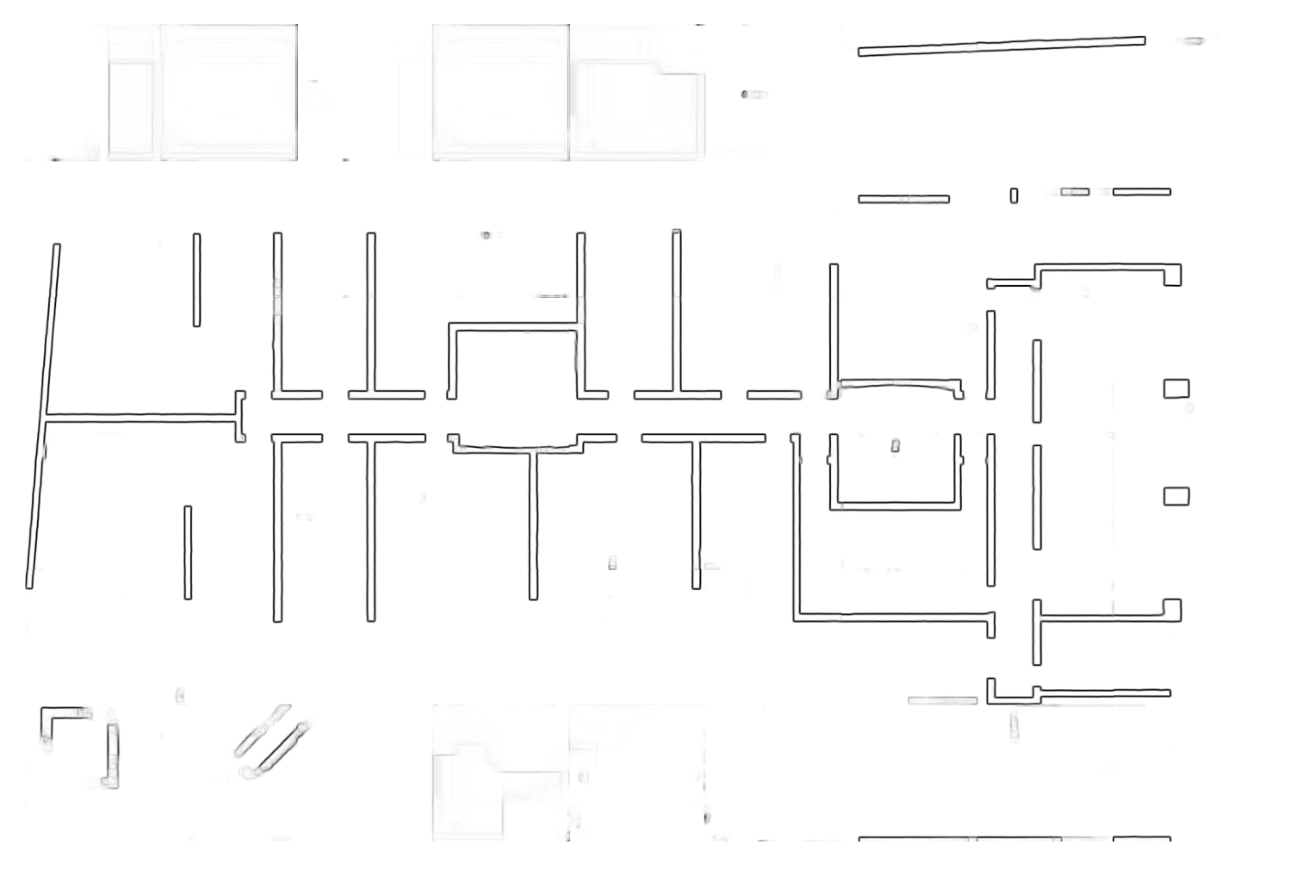

In [4]:
# Read the image
options = parse_args()
options.image_name = '1014539_outline.png'
images = read_data(options, image_type='L')
image = 1 - images[0]
plt.figure(dpi=250)
plt.imshow(image[0], 'gray')
plt.axis('off')

--- Preprocessing BEGIN
--- Preprocessing END


(-0.5, 1439.5, 959.5, -0.5)

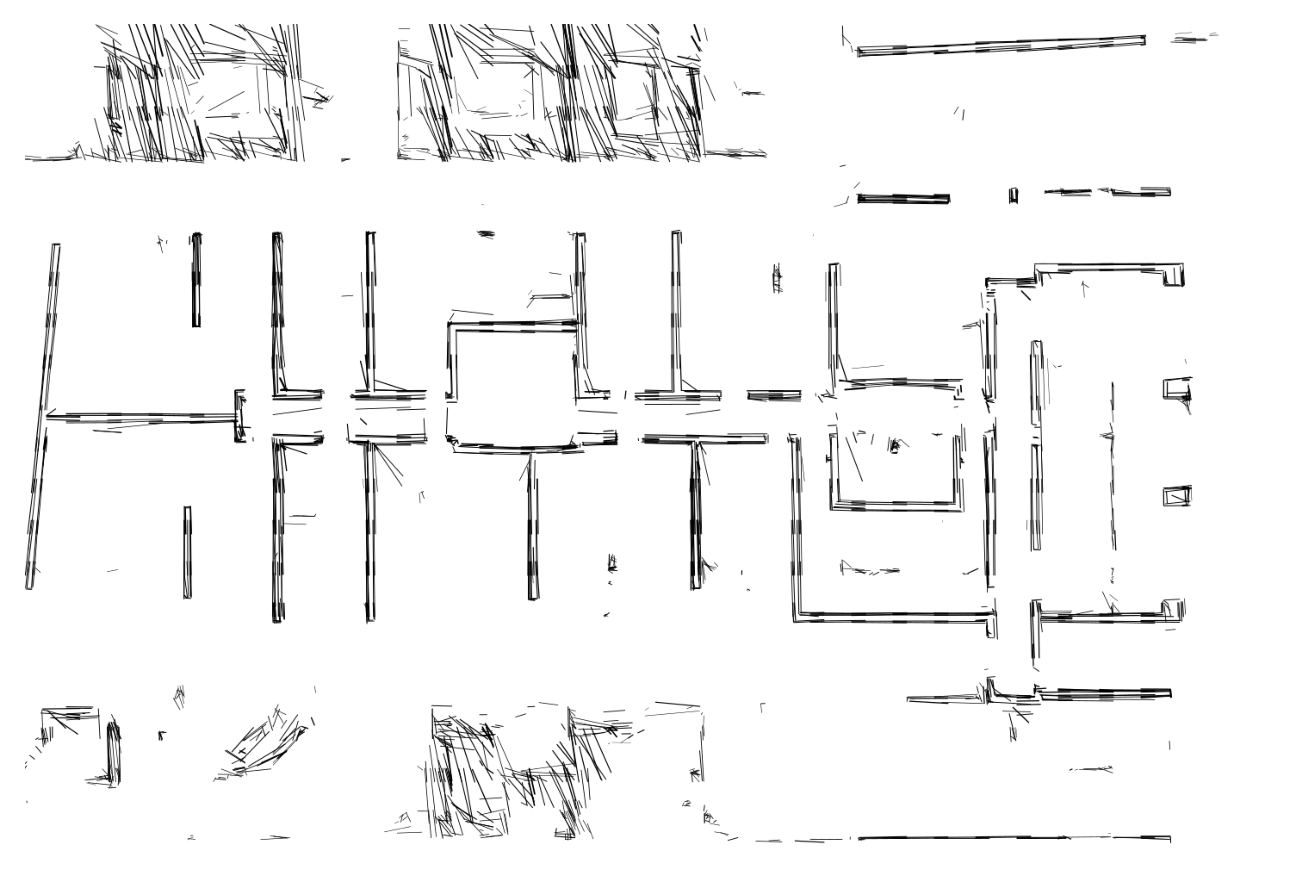

In [5]:
# Estimate primitives
image_tensor = image.unsqueeze(0).to(device)
patches_rgb, patches_offsets, input_rgb = split_to_patches(image_tensor.cpu().numpy()[0] * 255, 64, options.overlap)
model.eval()
patches_vector = []
print('--- Preprocessing BEGIN')
patch_images = preprocess_image(patches_rgb)
print('--- Preprocessing END')

for it_batches in range(400, patch_images.shape[0] + 399, 400):
    it_start = it_batches - 400
    if it_batches > patch_images.shape[0]:
        it_batches = patch_images.shape[0]
    with torch.no_grad():
        if(it_start==0):
            patches_vector = model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()
        else:
            patches_vector = np.concatenate((patches_vector,model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()),axis=0)
patches_vector = torch.tensor(patches_vector) * 64
rendered_image = save_svg(tensor_vector_graph_numpy(torch.tensor(patches_vector), patches_offsets, options), image_tensor.shape[1:],
             options.image_name[0], options.output_dir + 'model_output/')
plt.figure(dpi=250)
plt.imshow(rendered_image, 'gray')
plt.axis('off')
# plt.imsave(options.output_dir + 'model_output/'+ options.image_name[0],rendered_image)

init_random False


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:38<00:00,  1.89it/s]


0


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:26<00:00,  2.05it/s]


300


(-0.5, 1439.5, 959.5, -0.5)

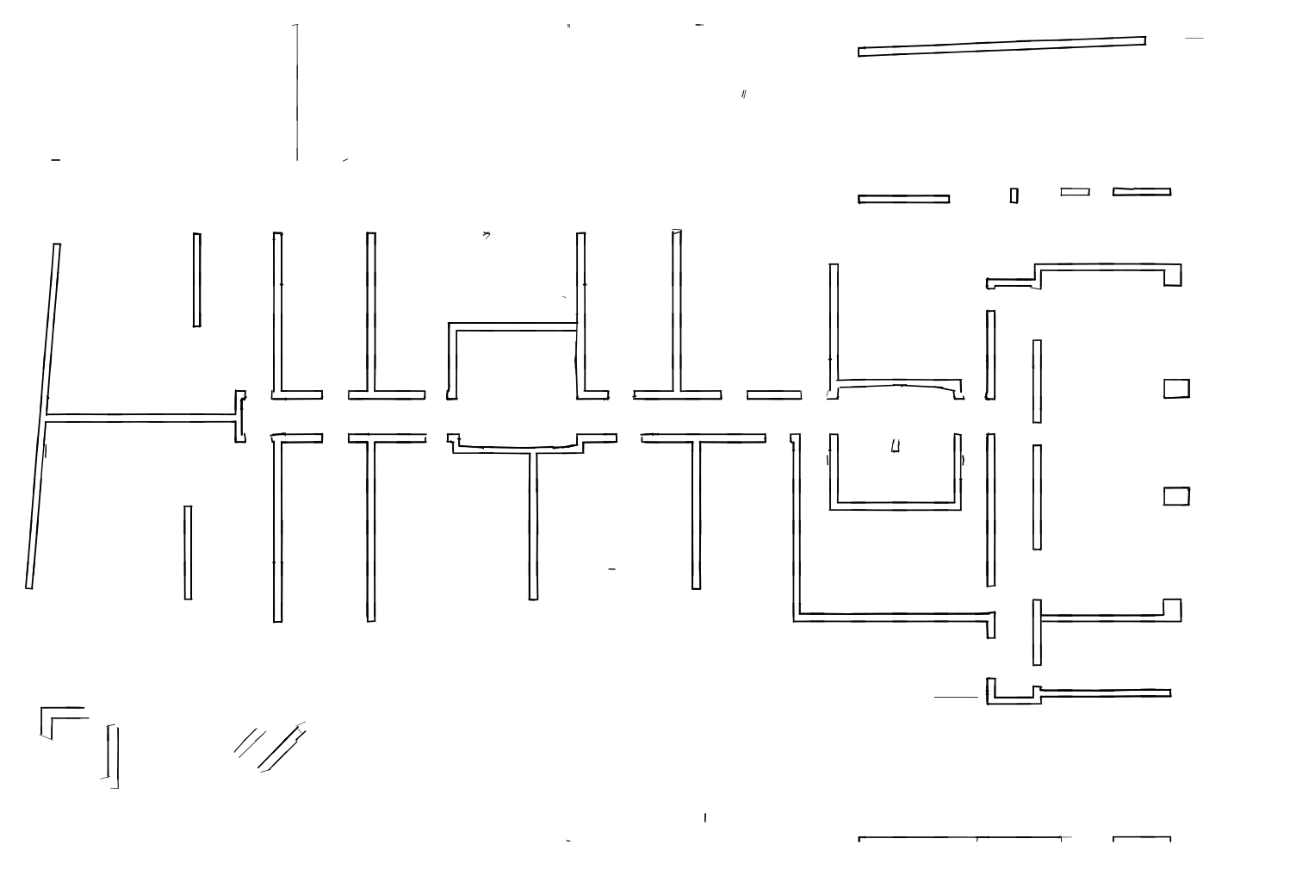

In [6]:
# Refinement
vector_after_opt = render_optimization_hard(patches_rgb, patches_vector, device, options, options.image_name[0])
rendered_image_opt= save_svg(tensor_vector_graph_numpy(vector_after_opt, patches_offsets, options), image.shape[1:],
         options.image_name[0], options.output_dir + 'diff_rendering_output/')
plt.figure(dpi=250)
plt.imshow(rendered_image_opt, 'gray')
plt.axis('off')

100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 136.74it/s]


(-0.5, 1439.5, 959.5, -0.5)

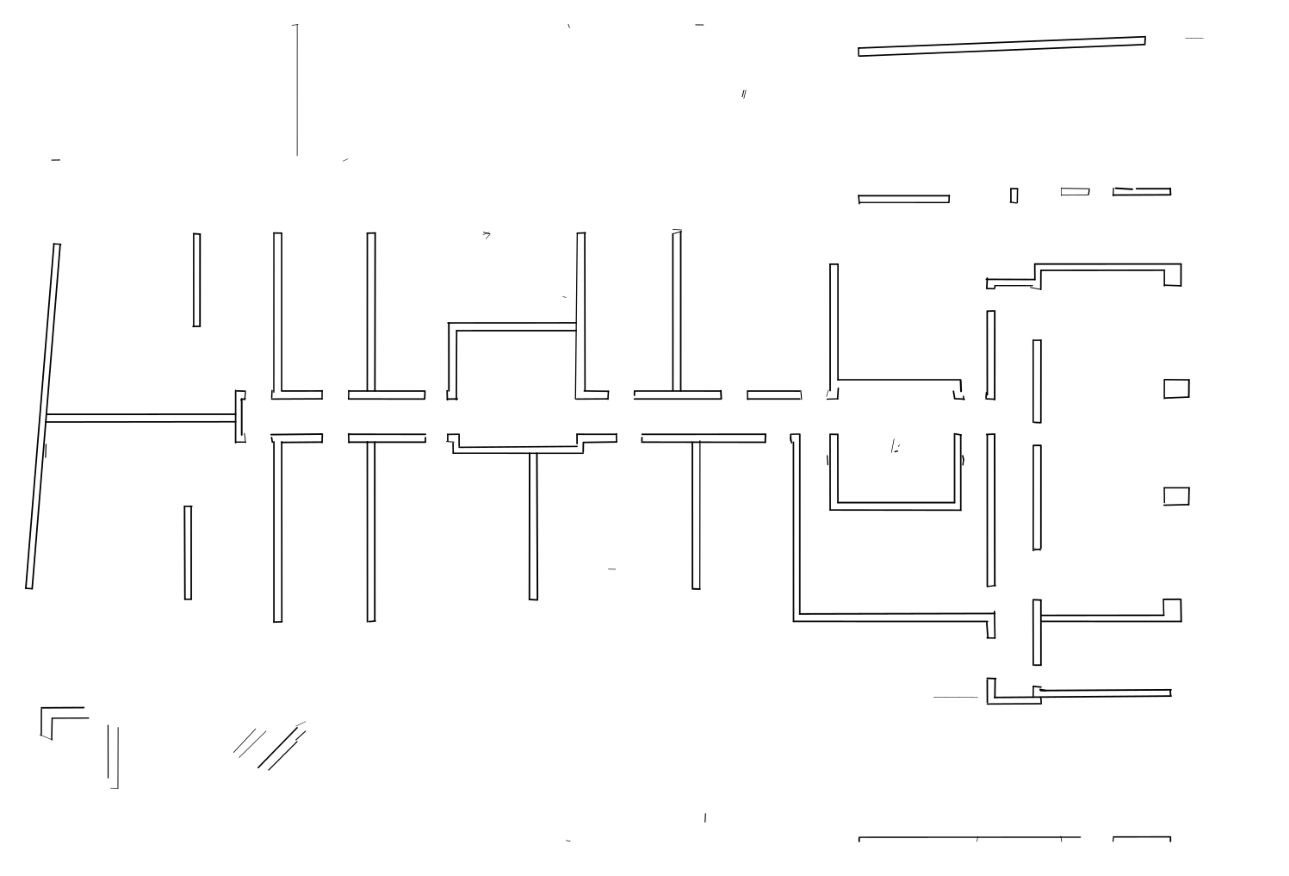

In [7]:
# Merge patches into final image
merging_result, rendered_merged_image = postprocess(vector_after_opt, patches_offsets, input_rgb, image, 0, options)
plt.figure(dpi=250)
plt.imshow(rendered_merged_image, 'gray')
plt.axis('off')

{'width': '1440px', 'height': '960px', 'viewBox': '0 0 1440 960', 'size': ('1440px', '960px')}


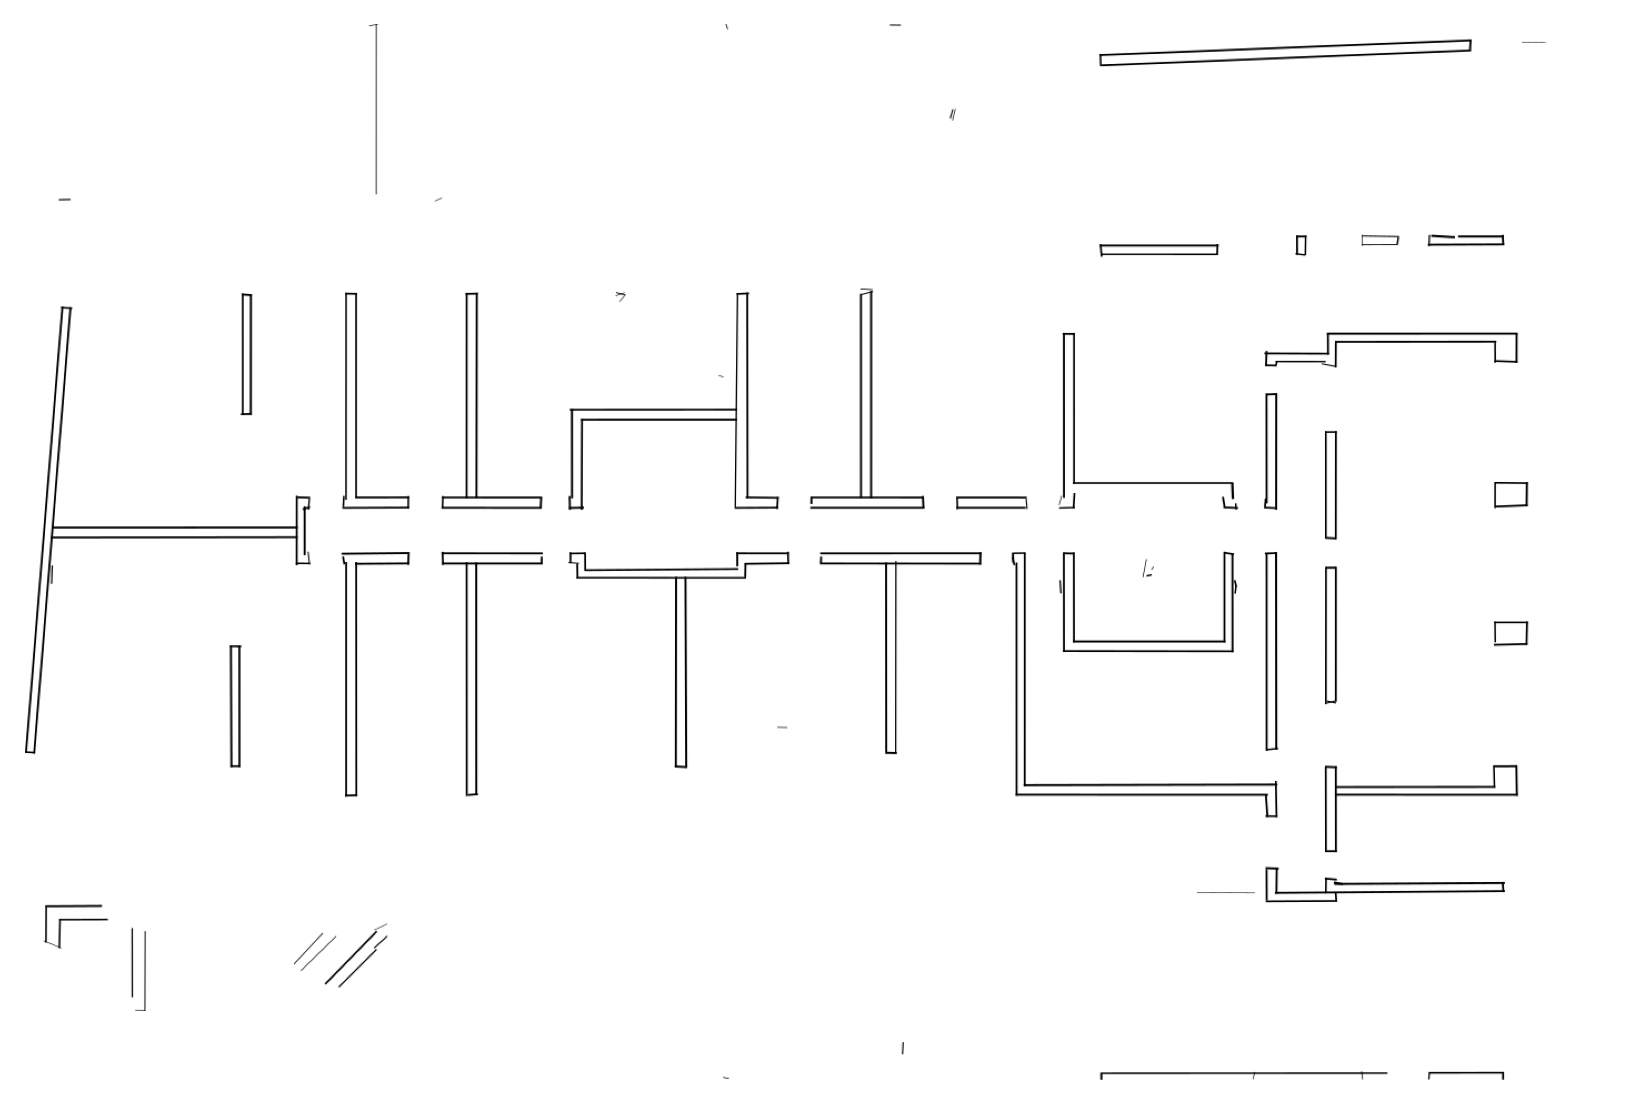

In [8]:
# Saving into svg format
bounding_boxes = np.array([0, image.shape[2], 0, image.shape[1]])
primitives = merging_result
paths = list(filter(None, map(primitive_to_path_and_crop,
                              zip(primitives[:,:5], bounding_boxes[None].repeat(primitives.shape[0],axis=0)))))
width = Pixels(image.shape[2])
height = Pixels(image.shape[1])
view_size = width, height

vector_image = VectorImage(paths, view_size=view_size)
fig = plt.figure(dpi=250)
plt.axis('off')
fig.patch.set_visible(False)
fig.tight_layout(pad=0)
plt.imshow(vector_image.render(render), 'gray')
if not os.path.exists(options.output_dir + '/svg/'):
    os.makedirs(options.output_dir + '/svg/')
vector_image.save(options.output_dir + '/svg/' + options.image_name[0][:-4] + '.svg')